In [1]:
# Check GPU device.
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


In [2]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string
import math

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

## Read and compile tranining and validation dataset.

In [3]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])

In [4]:
# df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc'] # Using raw.
df_train['input_text']=df_train['mission_spellchk']+df_train['prgrm_dsc_spellchk'] # Using spell-checked.
len(df_train['input_text']), len(df_train['NTEE1'].drop_duplicates())

(234027, 25)

In [5]:
# Build training and testing data frame.
small_num=0
while small_num<250: # Make sure each category has at least 500 records.
    sampleDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(150000)
    trainDF, valDF =train_test_split(sampleDF, test_size=.3)
    small_num=trainDF.groupby('NTEE1').count().sort_values('EIN').iloc[0]['EIN']

In [6]:
# See the composition by NTEE major groups.
print(trainDF.groupby('NTEE1').count()['EIN'], '\n'*2, valDF.groupby('NTEE1').count()['EIN'])

NTEE1
A    11693
B    17342
C     2315
D     3025
E     6599
F     1612
G     3641
H      349
I     2008
J     3003
K     1347
L     4014
M     2977
N    10098
O     1169
P     6636
Q     1462
R      766
S     9604
T     1461
U      695
V      255
W     5618
X     3022
Y     4289
Name: EIN, dtype: int64 

 NTEE1
A    4948
B    7395
C    1066
D    1262
E    2865
F     737
G    1486
H     129
I     900
J    1389
K     600
L    1716
M    1343
N    4308
O     505
P    2863
Q     591
R     318
S    4095
T     647
U     285
V     107
W    2339
X    1319
Y    1787
Name: EIN, dtype: int64


### Prepare labels.

In [7]:
def one_hot(label_list, class_list):
    int_encoder=LabelEncoder().fit(class_list) # Build the encoder.
    label_int_encoded=int_encoder.transform(label_list) # One-dimensional integer encoded.
    return np_utils.to_categorical(label_int_encoded) # Multi-dimensional binary/one-hot encoded.

y_train=one_hot(label_list=trainDF['NTEE1'], class_list=list(trainDF['NTEE1'].unique()))
y_val=one_hot(label_list=valDF['NTEE1'], class_list=list(trainDF['NTEE1'].unique()))

### Prepare input text.

In [8]:
stop_list=stopwords.words('english')+list(string.punctuation)
def stopwords_remove(token_list):
    global stop_list
    return [s for s in token_list if s not in stop_list]

In [9]:
text_token_list_train=trainDF['input_text'].apply(stopwords_remove)
text_token_list_val=valDF['input_text'].apply(stopwords_remove)

**Moved to preprocessing pipeline.**
```Python
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(word_string_list):
    return [SpellChecker().correction(word=s).upper() for s in word_string_list]

# Parallel computing
p = Pool(48)
text_token_list_train=p.map(spellcheck, text_token_list_train)
text_token_list_val=p.map(spellcheck, text_token_list_val)
# Pool.map keep the original order of data passed to map.
# https://stackoverflow.com/questions/41273960/python-3-does-pool-keep-the-original-order-of-data-passed-to-map
```

In [10]:
# Build word index for train and validation texts.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(text_token_list_train.to_list()+text_token_list_val.to_list())
print(list(tokenizer.word_index.items())[0:5])

[('and', 1), ('the', 2), ('to', 3), ('of', 4), ('in', 5)]


In [11]:
seq_encoding_text_train=tokenizer.texts_to_sequences(text_token_list_train)
seq_encoding_text_val=tokenizer.texts_to_sequences(text_token_list_val)

In [12]:
# Pads sequences to the same length.
x_train=pad_sequences(sequences=seq_encoding_text_train,
                      maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                      dtype = "int32", padding = "post", truncating = "post", 
                      value = 0 # Zero is used for representing None or Unknown.
                     )
x_val=pad_sequences(sequences=seq_encoding_text_val,
                    maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                    dtype = "int32", padding = "post", truncating = "post", 
                    value = 0 # Zero is used for representing None or Unknown.
                     )

## Word Embedding.

### Not using pre-trained embedding.

In [149]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index), # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=32, # Size of the vector space in which words will be embedded.
                           )

In [ ]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(max([len(s) for s in seq_encoding_text_train]),), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=len(y_train[0]), activation='softmax')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

In [150]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

# define the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(units=len(y_train[0]), activation='relu'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', precision, recall])
# summarize the model
print(model.summary())

In [ ]:
# fit the model
# Batch size: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
history=model.fit(x_train, y_train, validation_split=0.3, epochs=25, verbose=1)

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=1)
print('Accuracy: %f' % (accuracy*100))

### Use pre-trained GloVe embedding.

In [13]:
import gensim.downloader as api
EMBEDDING_DIM=100
glove_word_vector=api.load('glove-wiki-gigaword-'+str(EMBEDDING_DIM))

In [14]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))

In [15]:
for word, index in tqdm(tokenizer.word_index.items()):
    try:
        embedding_matrix[index] = glove_word_vector.get_vector(word)
    except:
        pass
        # words not found in embedding index will be all-zeros.

100%|██████████| 158688/158688 [00:00<00:00, 390283.81it/s]


In [16]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                            weights=[embedding_matrix],
                            trainable=False
                           )

### Stochastic tuning of training params.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf

with tf.device('/gpu:1'): # Specify which GPU to use.
    # define the model
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Flatten())
    model.add(Conv1D(128, 5, activation='softplus'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units=32, activation='sigmoid'))
    model.add(Dense(units=16, activation='softplus'))
    # model.add(PReLU()) # https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7
    model.add(Dense(units=16, activation='tanh'))
    model.add(Dense(units=16, activation='softplus'))
    model.add(Dense(units=len(y_train[0]), activation='softmax'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 
    #                                                                      precision, recall
                                                                        ])
    # summarize the model
    print(model.summary())

    # fit the model
    history=model.fit(x_train, y_train, validation_split=0.3, epochs=20, verbose=1)

### Try Grid Search.

In [17]:
# Continue previous work.
df_history=pd.read_csv('../../output/grid_search_history_major_group.tsv', sep='\t', index_col=0)

In [ ]:
param_list_done=set(map(tuple, 
                        df_history[['conv_num_filters', 'conv_kernel_size', 'conv_act', 'out_act']].values.tolist()
                       )
                   )

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
import tensorflow as tf
from datetime import datetime

# df_history=pd.DataFrame()
for num_filters in [32, 64, 128]:
    for kernel_size in [3,5,7]:
        for conv_act in ['sigmoid', 'softplus', 'tanh', 'softmax']:
            for out_act in ['sigmoid', 'softplus', 'tanh', 'softmax']:
                param=tuple((num_filters, kernel_size, conv_act, out_act))
                if param not in param_list_done:
                    t1=datetime.now()
                    # Run NN on a specified GPU.
                    with tf.device('/device:GPU:1'):
                        # define the model
                        model = Sequential()
                        model.add(embedding_layer)
                        # model.add(Flatten())
                        model.add(Conv1D(num_filters, kernel_size, activation=conv_act))
                        model.add(GlobalMaxPool1D())
                        model.add(Dense(units=32, activation='sigmoid'))
                        model.add(Dense(units=32, activation='softplus'))
                        model.add(Dense(units=16, activation='tanh'))
                        model.add(Dense(units=16, activation='softplus'))
                        model.add(Dense(units=len(y_train[0]), activation=out_act))
                        # compile the model
                        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
                        # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
                        # fit the model
                        history=model.fit(x_train, y_train, validation_split=0.2, epochs=50, verbose=0)
                        y_prob = model.predict(x_val, verbose=0)
                    # Save history.
                    acc = history.history['acc']
                    val_acc = history.history['val_acc']
                    loss = history.history['loss']
                    val_loss = history.history['val_loss']
                    epochs = range(1, len(acc) + 1)
                    # Calculate on validation dataset.
                    y_classes = y_prob.argmax(axis=-1)
                    y_classes_prob=[s.max() for s in y_prob]
                    y_classes_val=y_val.argmax(axis=-1)
                    df_val=pd.DataFrame({'pred':y_classes, 
                                         'true':y_classes_val, 
                                         'prob':y_classes_prob})
                    val_acc_real=len(df_val[df_val.pred==df_val.true])/len(df_val)
                    # Save history to datafame.
                    df_history_temp=pd.DataFrame()
                    df_history_temp['acc']=acc
                    df_history_temp['val_acc']=val_acc
                    df_history_temp['val_acc_real']=[math.nan]*(len(epochs)-1)+[val_acc_real]
                    df_history_temp['loss']=loss
                    df_history_temp['val_loss']=val_loss
                    df_history_temp['epochs']=epochs
                    df_history_temp['conv_num_filters']=[num_filters]*len(epochs)
                    df_history_temp['conv_kernel_size']=[kernel_size]*len(epochs)
                    df_history_temp['conv_act']=[conv_act]*len(epochs)
                    df_history_temp['out_act']=[out_act]*len(epochs)
                    df_history_temp['time_stamp']=[str(t1)]+[math.nan]*(len(epochs)-2)+[str(datetime.now())]
                    df_history=df_history.append(df_history_temp, ignore_index=True)
                    df_history.to_csv('../../output/grid_search_history_major_group.tsv', sep='\t')

## Check results.

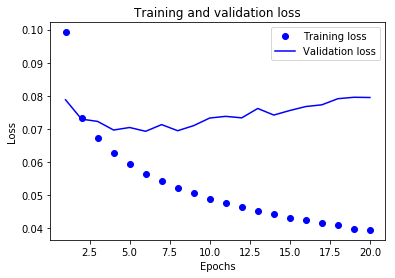

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

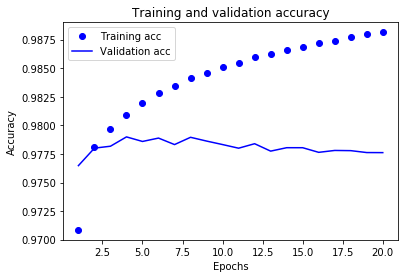

In [28]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
'''https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. 
The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.
In the case of a multi-class classification problem, the softmax activation function 
is often used on the output layer and the likelihood of the observation for each class is returned as a vector.
'''

y_prob = model.predict(x_val, verbose=1)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

60000/60000 [==============================] - 57s 947us/step


0.6837

In [47]:
'''https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. 
The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.
In the case of a multi-class classification problem, the softmax activation function 
is often used on the output layer and the likelihood of the observation for each class is returned as a vector.
'''

y_prob = model.predict(x_val, verbose=1)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

60000/60000 [==============================] - 67s 1ms/step


0.772

In [30]:
df_95=df_val[df_val.prob>.95]
print(len(df_95[df_95.pred==df_95.true])/len(df_95), len(df_95)/len(df_val))

0.9043997827267789 0.46025


In [25]:
df_95=df_val[df_val.prob>.95]
print(len(df_95[df_95.pred==df_95.true])/len(df_95), len(df_95)/len(df_val))

0.8247847099301924 0.8380166666666666


In [34]:
df_val.sample(10)

,pred,true,prob
24508,1,1,0.982052
5806,8,8,0.588295
38411,1,1,0.362110
36405,1,1,0.987800
24741,11,18,0.900885
19093,13,13,0.978523
31912,1,1,0.795643
27189,4,4,0.594007
25468,1,1,0.990625
893,15,1,0.955487


In [35]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0      6548.0  0.895009  0.179004  0.132235  0.895889  0.984995  0.993459   
1     10703.0  0.888338  0.180936  0.147765  0.894780  0.978533  0.988133   
2      1265.0  0.787910  0.213254  0.143312  0.645671  0.885924  0.964104   
3      1815.0  0.883840  0.189944  0.144596  0.874203  0.977297  0.994552   
4      4308.0  0.855663  0.202555  0.164770  0.787208  0.971184  0.989906   
5       803.0  0.696321  0.214642  0.173410  0.516907  0.728996  0.905332   
6      1774.0  0.641360  0.204593  0.135869  0.486512  0.668911  0.821526   
7        52.0  0.403332  0.078925  0.238325  0.326465  0.415584  0.468575   
8      1295.0  0.659798  0.234151  0.139096  0.456157  0.696444  0.883880   
9      1661.0  0.775016  0.225044  0.157899  0.596288  0.877797  0.965056   
10      801.0  0.673194  0.222252  0.174963  0.484500  0.710785  0.887294   
11     2736.0  0.774450  0.207941  0.158012  0.624839  0.879040  0.942594   
12     1678.0  0.873589  0.198027  0.151522  0.887529  0.971037  0.984812   
13     6183.0  0.899887  0.171034  0.147650  0.909504  0.982217  0.992061   
14      434.0  0.584106  0.198653  0.176205  0.410142  0.578708  0.757370   
15     4227.0  0.692852  0.228619  0.126495  0.499693  0.744948  0.905682   
16      771.0  0.510157  0.195483  0.140117  0.345483  0.501816  0.669224   
17      307.0  0.433083  0.192359  0.147781  0.285978  0.391007  0.553162   
18     5037.0  0.767665  0.253668  0.138688  0.560904  0.895692  0.988557   
19      139.0  0.228219  0.048581  0.124310  0.192914  0.223080  0.264735   
20      239.0  0.434444  0.131468  0.162479  0.329023  0.420549  0.541756   
21       25.0  0.303136  0.066490  0.179689  0.265337  0.292203  0.351449   
22     2846.0  0.882077  0.199181  0.145349  0.883274  0.985817  0.994503   
23     2007.0  0.699827  0.229800  0.152228  0.513699  0.761022  0.911728   
24     2346.0  0.801178  0.225391  0.140684  0.663363  0.914628  0.980358   

                
           max  
pred            
0     0.996476  
1     0.992789  
2     0.988802  
3     0.997026  
4     0.996556  
5     0.967258  
6     0.939298  
7     0.520184  
8     0.973886  
9     0.990586  
10    0.962535  
11    0.970933  
12    0.995105  
13    0.996537  
14    0.908809  
15    0.966472  
16    0.885243  
17    0.938684  
18    0.995088  
19    0.349515  
20    0.769116  
21    0.439437  
22    0.998688  
23    0.973591  
24    0.994963

In [35]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0     12602.0  0.848058  0.192906  0.099420  0.793265  0.942826  0.977441   
1     26000.0  0.809861  0.238692  0.087219  0.683788  0.946383  0.980377   
2      2297.0  0.605833  0.191890  0.094463  0.444121  0.639296  0.778246   
3      3366.0  0.874512  0.173787  0.157057  0.883541  0.956173  0.967872   
4      6441.0  0.741391  0.234529  0.126705  0.554008  0.835144  0.945148   
5      1366.0  0.386526  0.105981  0.138421  0.305284  0.385955  0.467187   
6      4108.0  0.498052  0.147095  0.093204  0.387617  0.518314  0.620197   
8      2320.0  0.352670  0.128075  0.114436  0.243909  0.338815  0.453435   
9      4780.0  0.656115  0.247266  0.120240  0.423637  0.723281  0.890782   
10     1540.0  0.504510  0.168473  0.120028  0.371044  0.496594  0.645774   
11     4314.0  0.715330  0.189366  0.112852  0.583356  0.787513  0.871542   
12     3242.0  0.877686  0.178106  0.129092  0.897202  0.958898  0.972096   
13    11921.0  0.839911  0.196575  0.118600  0.780404  0.941785  0.971170   
14     1574.0  0.418690  0.133496  0.140829  0.314354  0.406837  0.524091   
15    10648.0  0.547153  0.193563  0.109558  0.393835  0.548929  0.714959   
16      418.0  0.222347  0.045120  0.103251  0.193242  0.220646  0.252260   
17        1.0  0.130555       NaN  0.130555  0.130555  0.130555  0.130555   
18     9300.0  0.676713  0.271094  0.113672  0.425342  0.741195  0.942738   
19       87.0  0.169295  0.028792  0.112522  0.147757  0.165717  0.188771   
22     5613.0  0.813688  0.217035  0.120058  0.738421  0.924710  0.964420   
23     4228.0  0.618473  0.193106  0.099853  0.471122  0.656026  0.788790   
24     3834.0  0.724429  0.196630  0.097521  0.595665  0.792248  0.883907   

                
           max  
pred            
0     0.995070  
1     0.993897  
2     0.894880  
3     0.974627  
4     0.982064  
5     0.617621  
6     0.768572  
8     0.642961  
9     0.956166  
10    0.853527  
11    0.940572  
12    0.981479  
13    0.987029  
14    0.754473  
15    0.908429  
16    0.344682  
17    0.130555  
18    0.991517  
19    0.247617  
22    0.985283  
23    0.900154  
24    0.959967

## Draft.

In [208]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
'''
x = GRU(units=128, activation='tanh', return_sequences=True)(embedded_sequences)

x = LSTM(units=256, activation='tanh', return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)

#x = LSTM(units=128, activation='tanh', return_sequences=True)(x)
#x = Dropout(0.2)(x)
'''
# x = Dropout(0.2)(x)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=9, activation='softmax')(x) #softmax

# x = Dense(units=512, activation='relu')(x)
# x = Dense(units=128, activation='relu')(x)
# preds = Dense(units=25, activation='sigmoid')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 200)         6692600   
_________________________________________________________________
flatten_13 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               102400512 
_________________________________________________________________
dense_39 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_40 (Dense)             (None, 9)                 1161      
Total params: 109,159,937
Trainable params: 102,467,337
Non-trainable params: 6,692,600
______________________________________________________

In [79]:
score = model.evaluate(x_val, y_val, batch_size=500, verbose=1)
score

60000/60000 [==============================] - 25s 412us/step


[0.19112927243113517, 0.9295742606123288, 0.1111111119389534, 1.0]

In [34]:
len(df_val[df_val.pred==df_val.true])

37694

In [38]:
df_95.pred.unique()

array([1, 0, 7, 5, 3, 4, 2])